In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unrar x "/content/drive/MyDrive/aug_data.rar"

In [1]:
import tensorflow as tf
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras

**1. chargement des données**

In [2]:
def load_image(path):
    byte_img = tf.io.read_file(path)
    img = tf.io.decode_png(byte_img)
    return img

In [10]:
def load_data(name):
    images = tf.data.Dataset.list_files(os.path.join("aug_data",f'{name}\*.png'),shuffle=False)
    images = images.map(lambda x : tf.image.resize(load_image(x)/255,(120,120)))
    
    aug_data_frame = pd.read_csv(f"aug_annot_{name}.csv",index_col=False).sort_values(by="image")
    coords = ["x_min","y_min","x_max","y_max"]
    labels = tf.data.Dataset.from_tensor_slices(
        (tf.cast(aug_data_frame["classe"].values,tf.uint8),
        tf.cast(aug_data_frame[coords].values,tf.float32)
        ))
    print(len(labels))
    dataset = tf.data.Dataset.zip((images,labels))
    dataset = dataset.shuffle(len(images) + 500)
    dataset = dataset.batch(8)    
    dataset = dataset.prefetch(4)

    return dataset
    

In [4]:
def plot_images(batch,nbr_img):
    _,ax = plt.subplots(ncols=nbr_img,figsize=(20,20))
    for idx in range(nbr_img):
        sample_image = batch[0][idx]
        sample_classe = batch[1][0][idx]
        sample_coords = batch[1][1][idx]
        cv2.rectangle(sample_image, 
                    tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                    tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
        ax[idx].set_title("barcode" if sample_classe == 1 else "no_barcode")
        ax[idx].imshow(sample_image)

In [11]:
train = load_data("train")
val = load_data("val")
test = load_data("test")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
3808
1088
612


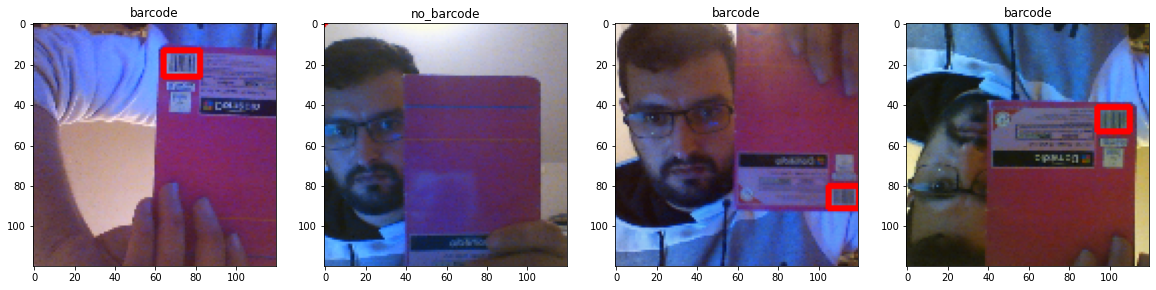

In [9]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
_,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_classe = res[1][0][idx]
    sample_coords = res[1][1][idx]
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)
    ax[idx].set_title("barcode" if sample_classe == 1 else "no_barcode")
    ax[idx].imshow(sample_image)
   

**2. construction du network**

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,Dense,GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [ ]:
# vgg = VGG16(include_top=False)
# vgg.summary()

In [11]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048,activation="relu")(f1)
    class2 = Dense(1,activation="sigmoid")(class1)

    f2 = GlobalMaxPooling2D()(vgg)
    reg1 = Dense(2048,activation="relu")(f2)
    reg2 = Dense(4,activation="sigmoid")(reg1)

    model = Model(inputs=input_layer,outputs=[class2,reg2])

    return model

In [12]:
BarcodeDetector = build_model()
# BarcodeDetector.summary()

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
X, y = train.as_numpy_iterator().next()

In [14]:
classe, coords = BarcodeDetector.predict(X)
classe, coords

1/1 [==============================] - 7s 7s/step


(array([[0.4083714 ],
        [0.43215698],
        [0.43698782],
        [0.36984   ],
        [0.3501959 ],
        [0.3963855 ],
        [0.4626924 ],
        [0.41035575]], dtype=float32),
 array([[0.32566994, 0.56412554, 0.41425213, 0.65543973],
        [0.27294448, 0.53286374, 0.42704964, 0.4835339 ],
        [0.43534243, 0.5391469 , 0.4540062 , 0.60001737],
        [0.41806963, 0.50552857, 0.33457506, 0.5233515 ],
        [0.42337567, 0.4570759 , 0.36536983, 0.5819317 ],
        [0.4497594 , 0.5202342 , 0.38035348, 0.5665787 ],
        [0.44660696, 0.54215056, 0.44383332, 0.5894092 ],
        [0.4619545 , 0.53221774, 0.35988417, 0.63316196]], dtype=float32))

**4. preparation des losses et optimizeure**

In [15]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1)/batches_per_epoch

In [16]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001,decay=lr_decay)

In [17]:
def loacalization_loss(y_true,y_hat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2]-y_hat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = y_hat[:,3] - y_hat[:,1] 
    w_pred = y_hat[:,2] - y_hat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size


In [18]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = loacalization_loss

In [19]:
print(classloss(y[0],classe))
print(regressloss(y[1],coords))

tf.Tensor(0.6662675, shape=(), dtype=float32)
tf.Tensor(3.1225572, shape=(), dtype=float32)


**5. creation du model final**

In [20]:
class BarcodeTracker(tf.keras.models.Model):
    def __init__(self,BarcodeDetector,**kwargs):
        super().__init__(**kwargs)
        self.model = BarcodeDetector 
    
    def compile(self, opt, classloss,loacalization_loss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = loacalization_loss
        self.opt = opt
    
    def train_step(self, batch,**kwargs):
        X,y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X,training = True)
            batch_classloss = self.closs(y[0],classes)
            batch_localloss = self.lloss(y[1],coords)

            total_loss = batch_classloss + 0.5*batch_localloss
            grad = tape.gradient(total_loss,self.model.trainable_variables)

        opt.apply_gradients(zip(grad,self.model.trainable_variables))

        return {"total_loss":total_loss,"class_loss":batch_classloss,"regress_loss":batch_localloss}
    
    def test_step(self, batch,**kwargs):
        X,y = batch
        classes, coords = self.model(X,training = False)

        batch_classloss = self.closs(y[0],classes)
        batch_localloss = self.lloss(y[1],coords)
        total_loss = batch_classloss + 0.5*batch_localloss

        return {"total_loss":total_loss,"class_loss":batch_classloss,"regress_loss":batch_localloss}

    def call(self, X, **kwargs):
        return self.model(X,**kwargs)
      
    def save(self,save_dir):
      return self.model.save(save_dir)
    

In [21]:
BarcodeDetectorFinal = BarcodeTracker(BarcodeDetector)
BarcodeDetector.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_1[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [22]:
BarcodeDetectorFinal.compile(opt,classloss,regressloss)

In [23]:
hist = BarcodeDetectorFinal.fit(train,epochs=10,validation_data=val)

Epoch 1/10
476/476 [==============================] - 52s 71ms/step - total_loss: 0.1298 - class_loss: 0.0510 - regress_loss: 0.1575 - val_total_loss: 9.3247e-04 - val_class_loss: 3.4654e-05 - val_regress_loss: 0.0018
Epoch 2/10
476/476 [==============================] - 49s 72ms/step - total_loss: 0.0345 - class_loss: 0.0119 - regress_loss: 0.0452 - val_total_loss: 3.6867e-04 - val_class_loss: 1.3620e-05 - val_regress_loss: 7.1010e-04
Epoch 3/10
476/476 [==============================] - 49s 72ms/step - total_loss: 0.0225 - class_loss: 0.0083 - regress_loss: 0.0283 - val_total_loss: 3.1781e-04 - val_class_loss: 6.8546e-07 - val_regress_loss: 6.3425e-04
Epoch 4/10
476/476 [==============================] - 50s 74ms/step - total_loss: 0.0125 - class_loss: 0.0050 - regress_loss: 0.0150 - val_total_loss: 6.7980e-04 - val_class_loss: 7.7563e-06 - val_regress_loss: 0.0013
Epoch 5/10
476/476 [==============================] - 49s 71ms/step - total_loss: 0.0123 - class_loss: 0.0053 - regress_

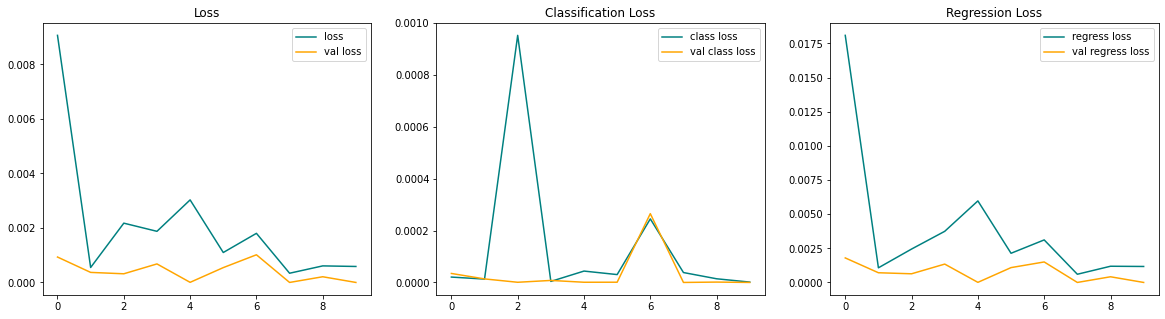

In [24]:

fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [25]:
BarcodeDetectorFinal.model.save("barcode_tracker.h5")

In [16]:
from keras.models import load_model
model_load = load_model("barcode_tracker.h5")

In [58]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()

In [59]:
y_pred = model_load.predict(test_sample[0])
y_pred

1/1 [==============================] - 0s 351ms/step


[array([[4.0039883e-15],
        [1.5690730e-08],
        [6.6814275e-12],
        [8.7557498e-14],
        [5.4505019e-18],
        [1.2371379e-12],
        [9.9987119e-01],
        [5.4110477e-14]], dtype=float32),
 array([[4.3860855e-08, 4.6359265e-08, 9.0329564e-08, 2.0743794e-07],
        [1.2933105e-04, 6.9799979e-05, 2.5046241e-04, 1.4352129e-04],
        [1.4342058e-06, 1.7507415e-06, 2.4604778e-06, 5.1829520e-06],
        [1.7627443e-07, 1.8094318e-07, 2.9596885e-07, 7.0140391e-07],
        [1.8992838e-09, 1.6298320e-09, 4.0009014e-09, 8.0847560e-09],
        [5.4412067e-07, 9.3328083e-07, 1.6399491e-06, 2.3718735e-06],
        [6.2612498e-01, 6.2876356e-01, 7.5744545e-01, 7.3116696e-01],
        [1.1909638e-07, 1.6453272e-07, 2.5037187e-07, 5.8383927e-07]],
       dtype=float32)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


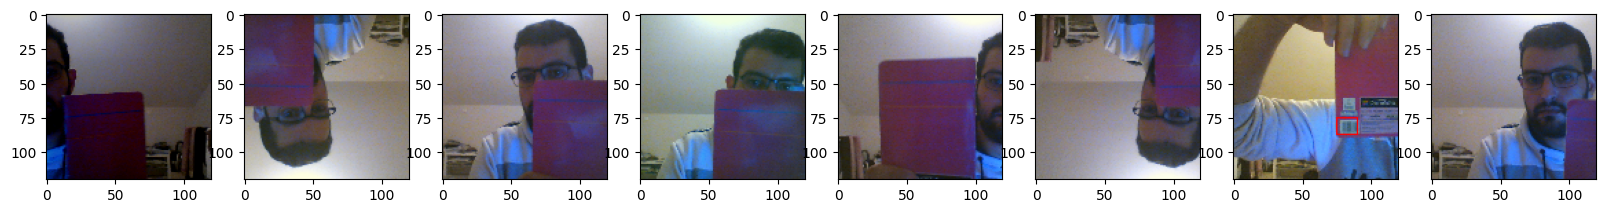

In [60]:
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx in range(8): 
    sample_image = test_sample[0][idx]
    sample_coords = y_pred[1][idx]
    
    if y_pred[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 1)
    
    ax[idx].imshow(sample_image)